In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [12]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    return train_dl, test_dl, valid_dl



In [16]:
class VAE(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.encorder = Encorder()
        self.decorder = Decorder()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        mean, var = self.encorder(x)
        z = self.reparameterize(mean, var)
        y = self.decorder(z)
        return y, z

    def reparameterize(self, mean, var):
        eps = torch.randn(mean.size()).to(self.device)
        z = mean + torch.sqrt(var) * eps
        return z
    
    def lower_bound(self, x):
        x = x.view(-1, 28*28)
        mean, var = self.encorder(x)
        z = self.reparameterize(mean, var)
        y = self.decorder(z)

        reconst = - torch.mean(torch.sum(x*torch.log(y)+(1-x)*torch.log(1-y), dim=1))

        kl = -1/2 * torch.mean(torch.sum(1+torch.log(var)-mean**2-var,dim=1))

        L = reconst + kl
        return L

class Encorder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28,200)
        self.l_mean = nn.Linear(200,10)
        self.l_var = nn.Linear(200,10)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, x):
        z = self.linear(x)
        z = self.relu(z)
        mean = self.l_mean(z)
        var = self.l_var(z)
        var = self.softplus(var)
        return mean, var

class Decorder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10,200)
        self.linear2 = nn.Linear(200,28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        y = self.linear1(z)
        y = self.relu(y)
        y = self.linear2(y)
        y = self.sigmoid(y)
        return y

In [20]:
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = 0
    iter_num = 0

    for datas, _ in dl:
        datas = datas.to(device)
        iter_num += 1

        if optimizer:
            loss = criterion(datas)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                loss = criterion(datas)
            
        losses += loss.item()

    return losses/iter_num
        

EPOCH:0, Train: loss=2.2e+02, Valid: loss=1.6e+02
EPOCH:5, Train: loss=1.24e+02, Valid: loss=1.24e+02
EPOCH:10, Train: loss=1.19e+02, Valid: loss=1.19e+02
EPOCH:15, Train: loss=1.16e+02, Valid: loss=1.17e+02
EPOCH:20, Train: loss=1.14e+02, Valid: loss=1.15e+02
EPOCH:25, Train: loss=1.13e+02, Valid: loss=1.14e+02
Best train loss=1.13e+02 Best valid loss=1.14e+02 Test loss=1.12e+02


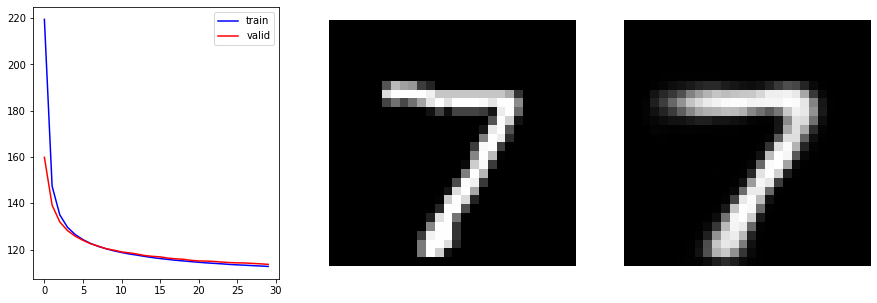

In [21]:
#VAE

# Constants
EPOCH_NUM = 30
TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, valid_dl = create_dataloader('MNIST', transform, valid=True)

model = VAE(device).to(device)
criterion = model.lower_bound
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)

train_loss_list, valid_loss_list = [], []
best_train_loss, best_valid_loss = None,None

testdata, _ = next(iter(test_dl))
testdata = testdata[0].to(device)

for epoch in range(EPOCH_NUM):
    train_loss = one_epoch(model, train_dl, device, criterion, optimizer)
    train_loss_list.append(train_loss)

    if epoch==0 or best_train_loss >= train_loss:
        best_train_loss = train_loss
    
    valid_loss = one_epoch(model, valid_dl, device, criterion)
    valid_loss_list.append(valid_loss)

    if epoch==0 or best_valid_loss >= valid_loss:
        best_valid_loss = valid_loss

        test_loss = one_epoch(model, test_dl, device, criterion)
        model.eval()
        with torch.no_grad():
            rec_data, z = model(testdata)
    if epoch%5 == 0:
        print('EPOCH:{:}, Train: loss={:.3}, Valid: loss={:.3}'.format(epoch, train_loss, valid_loss))
        
print('Best train loss={:.3} Best valid loss={:.3} Test loss={:.3}'.format(best_train_loss, best_valid_loss, test_loss))

fig = plt.figure(figsize=(15.0, 5.0))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(valid_loss_list, 'r', label='valid')
ax1.legend()

ax2 = fig.add_subplot(1,3,2)
testdata = testdata.view(28,28).detach().cpu().numpy()
ax2.imshow(testdata, cmap='binary_r')
ax2.axis('off')

ax3 = fig.add_subplot(1,3,3)
rec_data = rec_data.view(28,28).detach().cpu().numpy()
ax3.imshow(rec_data, cmap='binary_r')
ax3.axis('off')

plt.show()

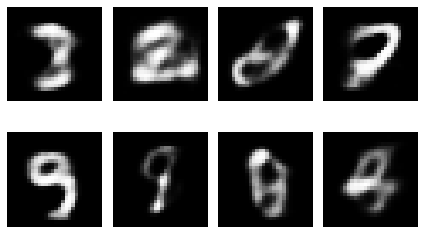

In [22]:
batch_size = 8
z = torch.randn(batch_size, 10, device=device)

model.eval()
g_imgs = model.decorder(z)
g_imgs = g_imgs.view(-1, 28, 28)
g_imgs = g_imgs.squeeze().detach().cpu().numpy()

for i, g_img in enumerate(g_imgs):
    plt.subplot(2,4,i+1)
    plt.imshow(g_img, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

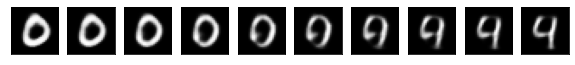

In [30]:
testdata, _ = next(iter(test_dl))
testdata0 = testdata[3].to(device)
testdata1 = testdata[4].to(device)

_, z0 = model(testdata0)
_, z1 = model(testdata1)

z1to0 = torch.cat([z1*(i*0.1)+z0*((9-i)*0.1) for i in range(10)]).reshape(10,10)
y = model.decorder(z1to0).view(-1,28,28)

fig = plt.figure(figsize=(10,1))
for i, img in enumerate(y.cpu().detach().numpy()):
    ax = fig.add_subplot(1,10,i+1, xticks=[], yticks=[])
    ax.imshow(img, 'gray')
